In [2]:
from ex1 import box3d, projectpoints
import matplotlib.pyplot as plt
import math
import numpy as np
import cv2
from numba import jit 
import logging;
logging.disable(logging.WARNING)

In [3]:
@jit
def euclidean_distance(r):
    return np.sqrt(r[0]**2 + r[1]**2)

In [4]:
@jit
def radial_distort(p, dist):
    """
    Distorts the points in vector P, based on distortion coefficients dist.
        rd = r(1+dr)
        dr = k3||r||^2 + k5||r||^2 + ...
    
    dist holds the k3, k5, ... koefficients and p holds all all vectors.
    """
    dist_p = np.zeros(shape=(p.T).shape)
    i = 0
    for r in p.T:
        dr = 0
        j = 2
        for k in dist:
            dr += k*euclidean_distance(r)**j
            j+=2

        dist_p[i] = r*(1+dr)
        i+=1
    return dist_p.T

In [5]:
def projectpoints_2(K, R, t, Q, dist):
    """
    Projects 3D points of an object to the 2D image plane of the camera.
    Using homogenous coordinates the process can be done like this:
            p_h = K*[R t]*P_h

    Parameters:
        - K: camera matrix - hold intrinsic camera info like focault distance and principal points
        - R, t: pose of camera transformation; scale and transport object to the camera plane.
        - Q: 3xn the n 3D points to be projected onto image plane.
        - dist: distortion coefficients list.
    
    Returns: 2xn matrix of projected points
    """
    # First creates the [R t] Matrix
    A = np.hstack((R, t))
    # Then, translate Q to homogenous plane => 4xn matrix by adding s=1
    B = np.vstack((Q, np.ones(len(Q[0]))))
    C = A@B
    # Return to non-homogenous coordinates
    p = C[0:2, :]/C[2, :]
    # Distort the result
    p = radial_distort(p, dist)
    q = np.vstack((p, np.ones(len(p[0]))))
    # Multiply by the camera matrix
    q = K@q
    # Translate back to cartesian coordinates and return (divide all by s, then remove s)
    return q[0:2, :]/q[2, :]

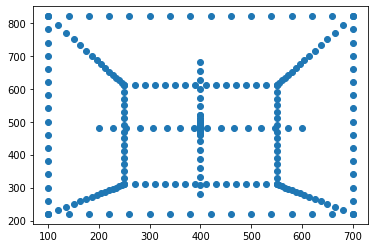

[[100.]
 [220.]]


In [6]:
# 2.1 Skew
Q = box3d(16)
f = 600
alpha = 1
beta = 0
dx = 400
dy = 400
K = np.array([[f, f*beta, dx], [0, f*alpha, dy], [0, 0, 1]])
t = np.array([[0, 0.2, 1.5]]).T
R = np.identity(3)
p = projectpoints(K, R, t, Q)
plt.scatter(p[0,:], p[1,:])
plt.show()

# Where does the corner P_1 = [−0.5, −0.5, −0.5] project to? 
P_1 = np.asarray([[-0.5, -0.5, -0.5]]).T
p = projectpoints(K, R, t, P_1)
print(p) # [100, 220].T

# Does the object fit the image?
# => dx, dy = 400 => 800x800 image, so some values are outside now.

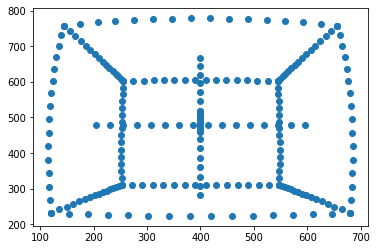

[[120.4 ]
 [232.24]]


In [7]:
# 2.2 Adding distortion
Q = box3d(16)
f = 600
alpha = 1
beta = 0
dx = 400
dy = 400
K = np.array([[f, f*beta, dx], [0, f*alpha, dy], [0, 0, 1]])
t = np.array([[0, 0.2, 1.5]]).T
R = np.identity(3)
dist = np.array([-0.2])
#dist = np.array([-0.245031, 0.071524, -0.00994978])

p = projectpoints_2(K, R, t, Q, dist)
plt.scatter(p[0,:], p[1,:])
plt.show()

# Where does the corner P_1 = [−0.5, −0.5, −0.5] project to? 
P_1 = np.asarray([[-0.5, -0.5, -0.5]]).T
p = projectpoints_2(K, R, t, P_1, dist)
print(p) # [120.4, 232.24].T

# Now the image will entirely be captured do to negative distortion coefficient

### 2.3 Captured by gopro

1080 1920 3


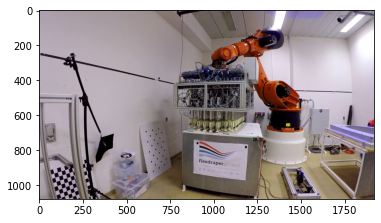

In [8]:
# Load image
img = cv2.imread('gopro_robot.jpg')
b,g,r = cv2.split(img)
img = cv2.merge([r,g,b])
plt.imshow(img)
(h, w, d) = img.shape
print(h, w, d)

In [9]:
# The K matrix
f = int(0.455732 * w)
dx = int(0.5*h)
dy = int(0.5*w)
dist = np.array([-0.245031, 0.071524, -0.00994978])
K = np.array([[f, 0, dx], [0, f, dy], [0, 0, 1]])
print(K)

[[875   0 540]
 [  0 875 960]
 [  0   0   1]]


### 2.4 Undistort
Having an undistorted image, make it undistorted:
1. Make a meshgrid with pixel coordinates for all pixels in an undistorted target image.
2. Distort this meshgrid using the algorithm. Now this is a mapping from the undistorted image and back to a non-distorted one.
3. Use the distorted meshgrid to extract color from the distorted image and paint in onto a new canvas.


Some improvements are still possible:
- Add a bigger meshgrid, so the entire image is captured: There are no reason for the meshgrid to be same size as the distorted image!
- Repeat the algorithm for each of the channels, to get the colour image.

In [10]:
import matplotlib.cm as cm

(1080, 1920)

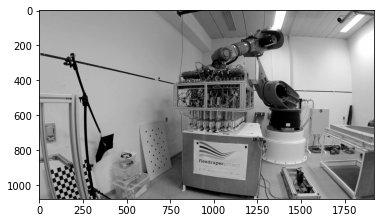

In [11]:
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.imshow(gray, cmap=cm.gray)
gray.shape

In [12]:

def undistortImage(gray, K, dist):
    """
    Undistorts an image by mapping the colors a new empty image.
    TODO: Assumes image is one single channel.
    """
    (height,width) = gray.shape
    ratio = height/width
    # Generate meshgrid of all pixels.
    scale = 1.2
    y, x = np.meshgrid(
        np.linspace(-scale, scale, num=width), np.linspace(-scale*ratio, scale*ratio, num=height))
    x=x.flatten()
    y=y.flatten()
    mapping_matrix = np.vstack((x, y)).astype(float) # [x, y]

    # Distort the grid
    p = radial_distort(mapping_matrix, dist)

    q = np.vstack((p, np.ones(len(p[0]))))
    # Multiply by the camera matrix
    q = K@q
    # Translate back to cartesian coordinates and return (divide all by s, then remove s)
    target_matrix = q[0:2, :]/q[2, :]

    # Target_matrix hold the distorted positions.
    canvas_matrix = np.zeros(shape=(int(height), int(width)), dtype=int)

    for i in range(height):
        for j in range(width):

            row = int(target_matrix[0][i*width + j]) 
            col = int(target_matrix[1][i*width + j])

            intensity = int(gray[row][col])
            canvas_matrix[i][j] = intensity




    return canvas_matrix

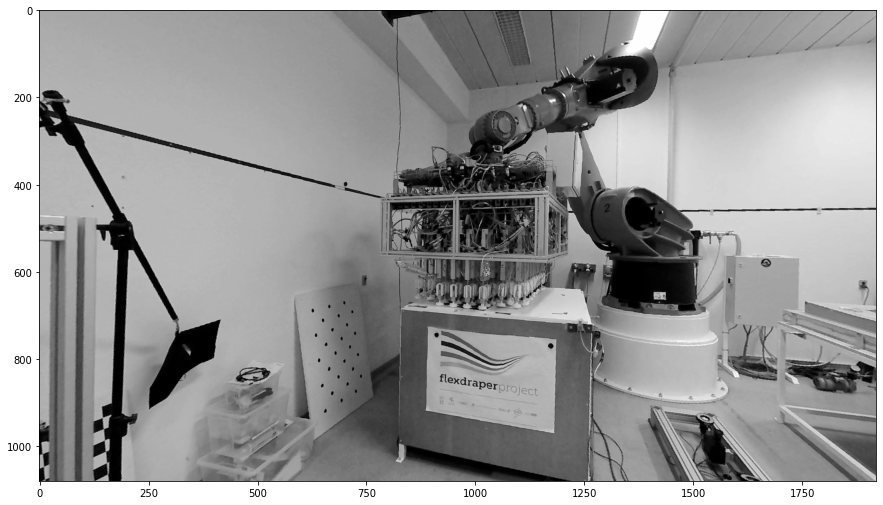

In [13]:
# The K matrix
(h, w) = gray.shape
f = int(0.455732 * w)
dx = int(0.5*h)
dy = int(0.5*w)
dist = np.array([-0.245031, 0.071524, -0.00994978])
K = np.array([[f, 0, dx], [0, f, dy], [0, 0, 1]])
canvas_matrix = undistortImage(gray, K, dist)
plt.figure(figsize=(15,15))
plt.imshow(canvas_matrix, cmap=cm.gray)
plt.show()


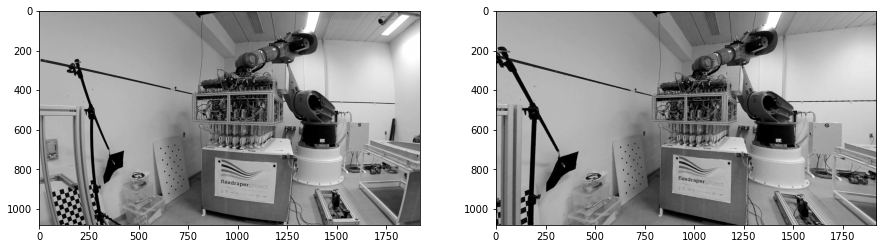

In [14]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(15,15))
ax1.imshow(gray, cmap=cm.gray)
ax2.imshow(canvas_matrix, cmap=cm.gray)

### 2.5 Homography
Given four points on a plane, use a given homography matrix to map the points to an image plane.

(The advantage of knowing the plane coordinates for the points is that we can use the 3x3 H matrix, instead of the 3x4 projection matrix.)

In [15]:
# Define all points and H matrix.
p1 = np.array([[1, 1]]).T
p2 = np.array([[0, 3]]).T
p3 = np.array([[2, 3]]).T
p4 = np.array([[2, 4]]).T
points = np.array([p1, p2, p3, p4])
H1 = np.array([[-2, 0, 1], [1, -2, 0], [0, 0, 3]])


In [16]:
def homography_mapping(q, H):
    ''' Calculats mapping to image plane, given H matrix.
    Nb! Assumes q is homogenous coordinate!'''
    return H@q


In [17]:
projections = []
Q1_l = []
Q2_l = []

for i in range(len(points)):
    p_h = np.vstack((points[i],1))
    Q1_l.append(p_h)
    q = homography_mapping(p_h, H1)
    Q2_l.append(q/q[2, :])
    q = q[0:2, :]/q[2, :]
    projections.append(q)

    

### 2.6 Estimate H - matrix
H matrix is a 3x3 matrix, but as it is scale invariant it has 8 degrees of freedom. Using 4 pais of (x,y) plane-points, we can therefor estimate H (as each pair implies 2 restrictions).
1. Calculate the B matrix = [B1, B2, B3, ...].T - one for each pair of point, by using kronecker and crossup operations.
2. Use SVD to solve the B flatten(H).T = 0 system (Ax = 0), by imposing that ||x|| = 1, to avoid the trivial solution.

In [18]:
## First construct Q1 and Q2 holding the image plane coordinates of the corresponding points:
Q1 = np.hstack(Q1_l[:])
Q2 = np.hstack(Q2_l[:])
Q1, Q2

(array([[1, 0, 2, 2],
        [1, 3, 3, 4],
        [1, 1, 1, 1]]),
 array([[-0.33333333,  0.33333333, -1.        , -1.        ],
        [-0.33333333, -2.        , -1.33333333, -2.        ],
        [ 1.        ,  1.        ,  1.        ,  1.        ]]))

In [19]:
def format_H_to_solution(H):
    ''' Helper function to scale H to appropriate value'''
    return H*(-2/H[0][0])

def hest(q1,q2):
    """
    Estimates H given points Q1, Q2 on the two image planes. 
    Need at least 4 pairs of points to estimate the matrix with 8 degrees of freedom.
    """
    assert len(q1[0])>1, "We need at least two points (aka two columns)" 
    assert len(q1[0])==len(q2[0]), "Number of column of q1 and q2 must be equal!"
    B = get_b(q1,q2) 
    _,_,VT = np.linalg.svd(B.T@B) #U,S,VT = np.linalg.svd(A.T@A)

    H = np.reshape(VT[-1],(3,3)) # VT is sorted in descending order of singular value
    return (H.T)

def get_b(q1,q2):
    """Calculates the B matrix by using kronecker multiplication and crossup setup."""
    B = np.kron(q2[:,0], np.array([[0,-1,q1[1,0]],[1,0,-q1[0,0]],[-q1[1,0],q1[0,0],0]]))
    for i in range(1,len(q1[0])):
        B_temp = np.kron(q2[:,i], np.array([[0,-1,q1[1,i]],[1,0,-q1[0,i]],[-q1[1,i],q1[0,i],0]]))
        B = np.vstack((B,B_temp))
    return B

H = hest(Q2,Q1)

print("Q1")
print(Q1)
print("Q2")
print(Q2)
print("H")
print(H.round(5))
print(format_H_to_solution(H).round(5))

Q1
[[1 0 2 2]
 [1 3 3 4]
 [1 1 1 1]]
Q2
[[-0.33333333  0.33333333 -1.         -1.        ]
 [-0.33333333 -2.         -1.33333333 -2.        ]
 [ 1.          1.          1.          1.        ]]
H
[[-0.45883  0.       0.22942]
 [ 0.22942 -0.45883 -0.     ]
 [-0.      -0.       0.68825]]
[[-2.  0.  1.]
 [ 1. -2. -0.]
 [-0. -0.  3.]]


H might seems a bit different from the original H, but that is only because its multiplied by a scaler such that ||H|| = 1, which is what SVD does to avoid trivial solutions.

### 2.7 Normalized  SVD

Its smart to normalize all points before applying the SVD, as it can be unstable otherwise. Normalized to zero mean and std = 1.

In [22]:
def normalize2d(Q):
    mean = np.mean(Q,axis=1)
    std = np.std(Q,axis=1)
    T = np.array([[1/std[0],0,-mean[0]/std[0]],
                  [0,1/std[1],-mean[1]/std[1]],
                 [0,0,1]])
    return [T@Q, T]

q_norm,T = normalize2d(Q1) #normalize all values in array
print(q_norm)
print(T)

[[-0.30151134 -1.50755672  0.90453403  0.90453403]
 [-1.60591014  0.22941573  0.22941573  1.14707867]
 [ 1.          1.          1.          1.        ]]
[[ 1.20604538  0.         -1.50755672]
 [ 0.          0.91766294 -2.52357307]
 [ 0.          0.          1.        ]]


### 2.8 Normalized SVD II

Use the normalization before running SVD, then return the points to non-normalized after.

In [27]:
def hest(q1,q2):
    """
    Estimates H given points Q1, Q2 on the two image planes. 
    Need at least 4 pairs of points to estimate the matrix with 8 degrees of freedom.
    """
    q1,T1 = normalize2d(q1)
    q2,T2 = normalize2d(q2)
    assert len(q1[0])>1, "We need at least two points (aka two columns)"
    assert len(q1[0])==len(q2[0]), "Number of column of q1 and q2 must be equal!"
    B = get_b(q1,q2) #np.vstack((B0,B1))
    _,_,VT = np.linalg.svd(B.T@B) #U,S,VT = np.linalg.svd(np.hstack((B.T,B)))
    H = np.reshape(VT[-1],(3,3)) # VT is sorted in descending order of singular value
    return (np.linalg.inv(T1)@H.T@T2.round(2))

def get_b(q1,q2):
    B = np.kron(q2[:,0], np.array([[0,-1,q1[1,0]],[1,0,-q1[0,0]],[-q1[1,0],q1[0,0],0]]))
    for i in range(1,len(q1[0])):
        B_temp = np.kron(q2[:,i], np.array([[0,-1,q1[1,i]],[1,0,-q1[0,i]],[-q1[1,i],q1[0,i],0]]))
        B = np.vstack((B,B_temp))
    return B


H = hest(Q2,Q1)
print("q1")
print(Q1)
print("q2")
print(Q2)
print("H")
print(format_H_to_solution(H).round(2))

q1
[[1 0 2 2]
 [1 3 3 4]
 [1 1 1 1]]
q2
[[-0.33333333  0.33333333 -1.         -1.        ]
 [-0.33333333 -2.         -1.33333333 -2.        ]
 [ 1.          1.          1.          1.        ]]
H
[[-2.   -0.    1.  ]
 [ 1.   -2.   -0.01]
 [ 0.   -0.    2.99]]


### 2.9 Test setup

Generate 100 random points, and random H. Map the points using H, then use hest to estimate the random H.

In [64]:
import random
H = np.array([[-2,0,1],[1,-2,0],[0,0,3]])

def rnd():
    ''' Returns a random number between 1 and 5'''
    return random.randint(1,5)

def random_generator(n):
    ''' Generate a random point matrix of length n'''
    q = np.array([[rnd(), rnd(), rnd()]]).T
    for i in range (n):
        q = np.hstack((q,np.array([[rnd(), rnd(), rnd()]]).T))
    return q

def q1_from_q2_2D(q1, H ):
    ''' Uses H matrix to '''
    # Gets the q2 points using H matix
    q2 = H@q1
    return q2/q2[2, :] # Make sure s = 1 

q2 = random_generator(100)
q1 = q1_from_q2_2D(q2, H)
H_est = hest(q1,q2)
print("H_est")
print(format_H_to_solution(H_est).round(2))
print("H")
print(H)


H_est
[[-2.   -0.    1.01]
 [ 1.   -1.99 -0.01]
 [-0.    0.    3.  ]]
H
[[-2  0  1]
 [ 1 -2  0]
 [ 0  0  3]]
